#### Model

$$ \frac{d}{dt}N_0(t) = - \alpha _0 \cdot N_0(t) - \beta _0 \cdot N_0(t)

$$ \frac{d}{dt}N_1(t) = 2 \alpha _0 \cdot N_0(t) - \alpha _1 \cdot N_1(t) - \beta _1 \cdot N_1(t)

$$ \frac{d}{dt}N_j(t) = 2 \alpha _{j-1} \cdot N_{j-1}(t) - \alpha _j \cdot N_1(t) - \beta _j \cdot N_1(t) $$

$$ \frac{d}{dt}D(t) = \sum_{j=0}^{J} \beta _j N_j(t) - \delta D(t)

Model solution

$$N_j(t) = e^{-c(t-t_0)} \sum_{i=0}^j (2 \alpha)^i \frac{(t - to)^i}{i!} N_{j - i}(t_0), \quad j = 0, 1, ..., J $$

$$D(t) = \beta \sum_{j = 0}^J \sum_{i = 0}^j (2 \alpha)^iN_{j - i}(t_0) \Bigg\{ \frac{(-1)^i}{(\delta - c)^{i+1}} \Bigg(e^{(\delta - c)(t - t_0)}  \sum_{k = i}^0 \frac{((t - t_0)(c - \delta))^k}{k!} - 1\Bigg) \Bigg\} \cdot e^{- \delta (t - t_0)} + D(t_0)e^{- \delta (t - t_0)} $$

$$ c = \alpha + \beta$$

#### Init data
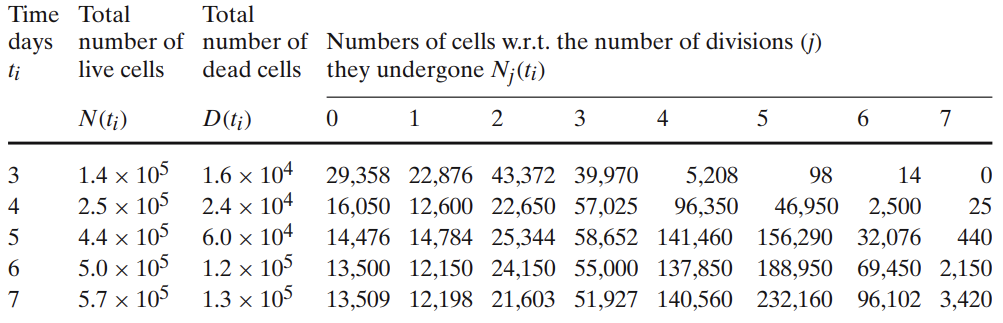

In [476]:
import numpy as np
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [477]:
D = np.array([1.6, 2.4, 6.0, 1.2, 1.3]) * 1e4

N = np.array([[29358, 22876, 43372, 39970, 5208, 98, 14, 1],
                [16050, 12600, 22650, 57025, 96350, 46950, 2500, 25],
                [14476, 14784, 25344, 58652, 141460, 156290, 32076, 440],
                [13500, 12150, 24150, 55000, 137850, 188950, 69450, 2150],
                [13509, 12198, 21603, 51927, 140560, 232160, 96102, 3420]])

t0 = 72
step = 0.0005
t1 = 72 + 24 * (len(D) - 1) + step
t_eval = np.arange(t0, t1, step) # + 1 is to include last t cause range stop is excludive
p = np.array([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-3, 1e-2, 1, 1e-15, 1e-13, 1e-13, 1e-14, 1e-3, 1e-2, 1e-15, 1e-11, 1e-2])
# p = np.log(p)
y_init = np.concatenate((N[0], [D[0]]))
t_eval

array([ 72.    ,  72.0005,  72.001 , ..., 167.999 , 167.9995, 168.    ])

$$y = [N_0, N_1, ..., N_J]$$

In [478]:
def f(t, y, p):
    [alpha, beta, delta] = p
    N = y[0:-1]
    D = y[-1]
    result = []
    for j, _ in enumerate(N):
        if j == 0:
            dN_dt = -(alpha[j] + beta[j]) * N[j]
            result.append(dN_dt)
        else:
            dN_dt = 2 * alpha[j - 1] * N[j - 1] - (alpha[j] + beta[j]) * N[j]
            result.append(dN_dt)

    dD_dt = np.sum(beta * N) - delta * D
    result.append(dD_dt)

    return np.array(result)
        
        

$$ \Phi(p) = \sum_{i=1}^4\bigg(\sum_{j=0}^7(N_j^i - N_j(t_i, p))^2 + (D^i - D(t_i, p))^2\bigg) $$

In [479]:
def Phi(p):

    # p = np.exp(p)
    alpha = p[:len(p) // 2]
    beta =  p[len(p) // 2:-1]
    delta = p[-1]
    # print(p)

    p = [alpha, beta, delta]
    sol = solve_ivp(fun=f, t_span=[t0, t1], y0=y_init, method='RK45', t_eval=t_eval, args=[p])
    N_num = np.array([np.array(N_[::int(24 / step)]) for N_ in sol.y[0:-1]]).transpose()
    D_num = np.array(sol.y[-1][::int(24 / step)])

    assert N_num.shape == (5, 8), sol.y


    return np.sum((N - N_num)**2) + np.sum((D - D_num)**2)
    # return np.sum(np.log(N + 1) - np.log(N_num + 1))**2 + np.sum(np.log(D + 1) - np.log(D_num + 1))**2


In [480]:
res = minimize(Phi, p)
print(res.x)

[-0.01173646  0.15357945  0.04381018  0.06391225  0.02588433  0.00824278
  0.05660157  5.13649083  0.02455463 -0.17310757  0.16914575 -0.02641188
  0.02376834  0.01985783 -0.02785992 -1.70534038  0.08258381]


In [486]:
print(Phi(res.x) * 1e-9)

1.468278642483487


In [481]:
alpha = res.x[:len(p) // 2]
beta =  res.x[len(p) // 2:-1]
delta = res.x[-1]
p = [alpha, beta, delta]
sol = solve_ivp(fun=f, t_span=[t0, t1], y0=y_init, method='RK45', t_eval=t_eval, args=[p])
N_num = np.array([np.array(N_) for N_ in sol.y[0:-1]]).transpose()
D_num = np.array(sol.y[-1])
t_num = np.array(sol.t)

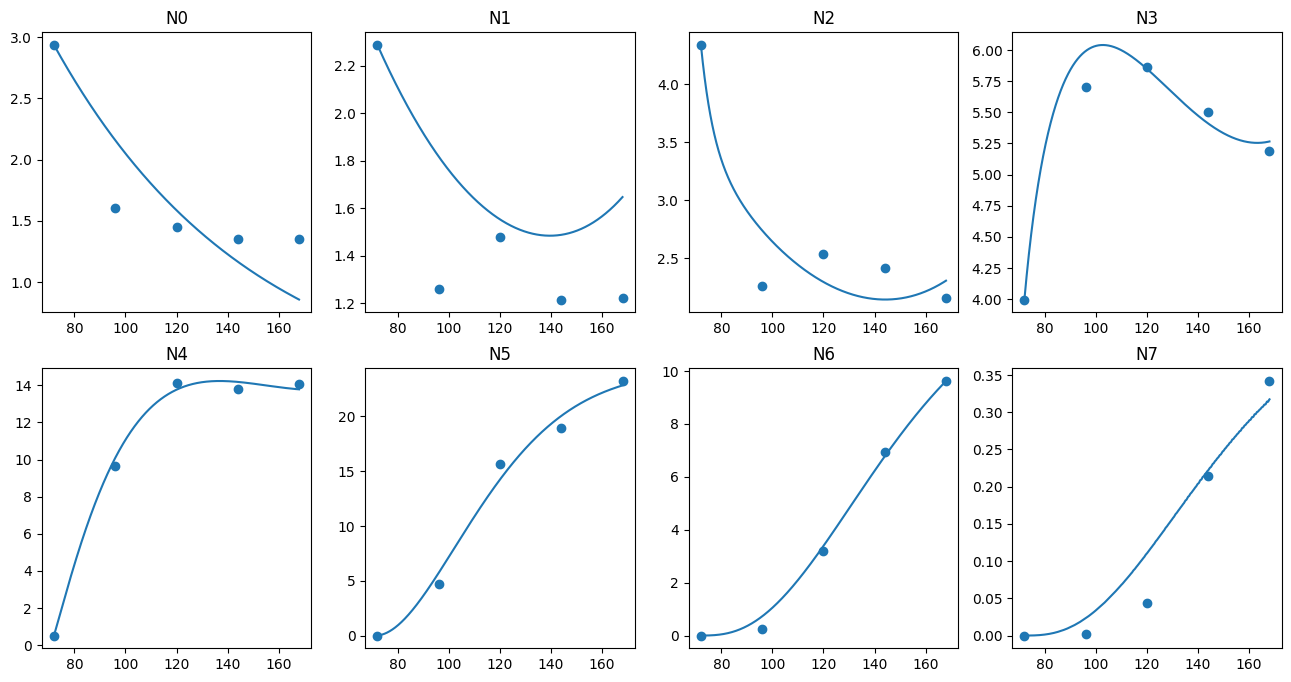

In [482]:
import matplotlib.pyplot as plt
[n, m] = N.shape
pos0 = 221

plt.figure(figsize=(16, 8))


for i in range(m):
   plt.subplot(2, 4, i + 1)
   plt.plot(t_num, N_num[:, i] * 1e-4)
   plt.scatter(t_eval[::int(24 / step)], N[:, i] * 1e-4)
   plt.title('N' + str(i))
    
    

In [ ]:
print(p)
print(Phi())